# 08: statistical $ ML methods

In [35]:
# read the csvs
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

baseline = pd.read_csv('patient_baseline.csv',sep='\t')
longitudinal = pd.read_csv('patient_longitudinal.csv', sep='\t')
treatment = pd.read_csv('patient_treatment.csv', sep='\t')

## Time Series Tasks
1. Convert the longitudinal blood pressure measurements into a proper time series:
   - Create a pandas Series with DatetimeIndex using `visit_date`
   - Handle any missing or duplicate measurements appropriately
   - Tips: 
     - Use `pd.to_datetime()` with format='%Y-%m-%d' for reliable parsing
     - Handle duplicates with `duplicated()` and appropriate aggregation
     - Consider timezone handling with `tz_localize()` if needed
     - Use `interpolate()` or `fillna()` for missing values

In [36]:
# longitudinal['visit_date'].head()
# longitudinal['bp_systolic'].head()
visit_date = pd.to_datetime(longitudinal['visit_date'], format='%Y-%m-%d')
ts = pd.Series(longitudinal['bp_systolic'].values, index=visit_date)
ts = ts[~ts.index.duplicated(keep='first')] # remove duplicates
ts = ts.resample('D').mean() # resample to daily
ts.interpolate(method='linear', inplace=True) # interpolate missing values
ts = ts.fillna(method='ffill') # fill missing values
ts.head()

visit_date
2023-01-17    108.600000
2023-01-18    108.494444
2023-01-19    108.388889
2023-01-20    108.283333
2023-01-21    108.177778
Freq: D, dtype: float64

2. Analyze blood pressure trends:
   - Resample the data to monthly frequency using mean aggregation
   - Calculate 3-month moving averages to smooth out short-term fluctuations
   - Visualize both the original and smoothed trends
   - Tips:
     - Use `resample('ME').mean()` for month-end frequency
     - Add `min_periods` to `rolling()` to handle edge cases
     - Consider `interpolate()` method for gaps
     - Use `ewm()` for exponential weighted alternatives

In [37]:
cp = ts.copy()
cp = cp.resample('M').mean()
assert(cp.isna().sum() == 0)
# add min_periods to rolling()
cp = cp.rolling(window=3, min_periods=1).mean() 
# consider interpolation
cp = cp.interpolate(method='linear')
cp.head()

visit_date
2023-01-31    107.861111
2023-02-28    106.785369
2023-03-31    106.555448
2023-04-30    107.446078
2023-05-31    110.522869
Freq: M, dtype: float64

## Statistical Modeling Tasks

1. Analyze factors affecting baseline blood pressure:
   - Use statsmodels OLS to predict `bp_systolic`
   - Include `age`, `bmi`, `smoking`, and `diabetes` as predictors
   - Interpret the coefficients and their p-values
   - Assess model fit using R-squared and diagnostic plots
   - Tips:
     - Create feature matrix `X` with predictors and add constant term using `sm.add_constant()`
     - Use `sm.OLS(y, X).fit()` to fit the model
     - Use `summary()` to examine p-values and confidence intervals
     - Plot residuals vs fitted values and Q-Q plot
     - Consider robust standard errors with `HC3` covariance type

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     150.2
Date:                Thu, 07 Nov 2024   Prob (F-statistic):          1.65e-100
Time:                        12:22:45   Log-Likelihood:                -3700.7
No. Observations:                1000   AIC:                             7411.
Df Residuals:                     995   BIC:                             7436.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      2.000     54.252      0.0

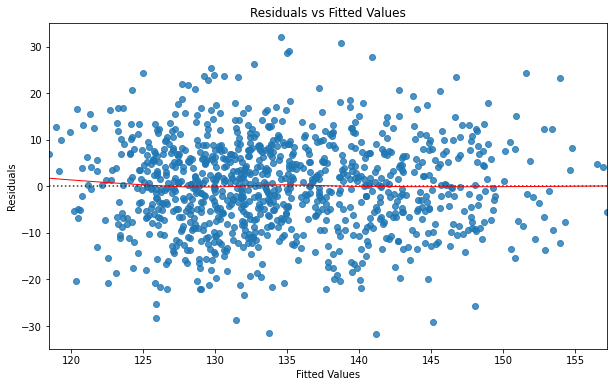

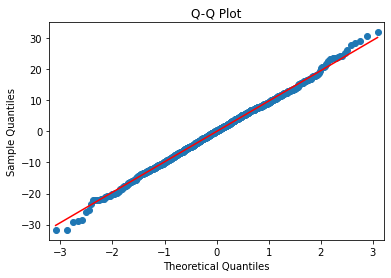

In [38]:
X = baseline[['age', 'bmi', 'smoking', 'diabetes']]
y = baseline['bp_systolic']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

plt.figure(figsize=(10, 6))
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()
sm.qqplot(model.resid, line='s')
plt.title('Q-Q Plot')
plt.show()

2. Model treatment effectiveness:
   - Fit a GLM with binomial family to predict treatment success
   - Use baseline characteristics and `adherence` as predictors
   - Report odds ratios and their confidence intervals
   - Assess model fit using deviance and diagnostic plots
   - Tips:
     - Create feature matrix `X` with predictors and add constant term
     - Use `sm.GLM(y, X, family=sm.families.Binomial()).fit()`
     - Get odds ratios with `np.exp(params)`
     - Check residual deviance vs null deviance
     - Use `influence()` to detect influential observations